In [1]:
import torch
import torchmetrics
import torch.nn as nn
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Vanishing/Exploding Gradient Problem

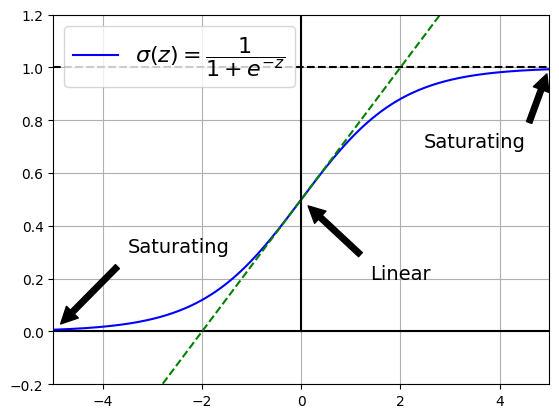

In [3]:
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

z = np.linspace(-5,5,300)
plt.axis([-5,5,-0.2,1.2])
plt.plot([-5,5], [0,0], "k-")
plt.plot([-5,5], [1,1], "k--")
plt.plot(z, sigmoid(z), "b-", label = r"$\sigma(z) = \dfrac{1}{1 + e^{-z}}$")
plt.grid()
plt.legend(fontsize=16)
plt.plot([0,0], [0,1.2], "k-")
plt.plot([-5,5], [-3/4, 7/4], "g--")
props = dict(facecolor='black', shrink=0.1)
plt.annotate("Saturating", xy=(5,1), xytext=(3.5, 0.7), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate("Linear", xy=(0,0.5), xytext=(2,0.2),arrowprops=props,
             ha="center", fontsize=14)
plt.annotate("Saturating", xy=(-5,0), xytext=(-3.5, 0.3), arrowprops=props, 
             fontsize=14)
plt.show()

#### Glorot and He Initialization

In [4]:
layer = nn.Linear(40,10)
layer.weight.data *= 6 ** 0.5 # kaiming init
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
# A more clearer approach

nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [6]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)
model = nn.Sequential(
    nn.Linear(50,40),
    nn.ReLU(),
    nn.Linear(40,10),
    nn.ReLU()
)

model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=10, bias=True)
  (3): ReLU()
)

#### Leaky ReLU

LeakyReLU(z) = max($\alpha$ z,z)

Text(-3.7, 0.25, 'Leak')

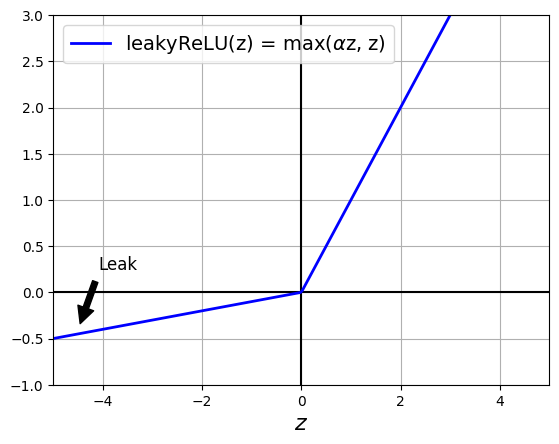

In [7]:
z = np.linspace(-5, 5, 300)
def leakyReLU(z, alpha):
    return np.maximum(alpha * z, z)

props = dict(facecolor="black", shrink=0.1)

plt.plot([-5,5], [0,0], "k-")
plt.plot([0,0], [-1,5], "k-")
plt.grid()
plt.plot(z, leakyReLU(z, 0.1), "b-", linewidth=2, label = r"leakyReLU(z) = max($\alpha$z, z)")
plt.legend(fontsize = 14)
plt.axis([-5,5, -1,3])
plt.xlabel("$z$", fontsize=16)
plt.annotate("Leak", xy=(-4.5, -0.4), xytext=(-3.7, 0.25), ha="center",
             arrowprops=props, fontsize = 12)

#### ELU and SELU

ELU($z$) = $\alpha$ ($e^z$ - 1) if $z$ < $0$, else $z$

SELU($z$) = 1.05ELU<sub>1.67</sub>($z$)

#### Batch Normalization

In [8]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1*28*28),
    nn.Linear(1*28*28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300,100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100,10)
)

In [9]:
dict(model[1].named_parameters()).keys()

dict_keys(['weight', 'bias'])

In [10]:
dict(model[1].named_buffers()).keys()

dict_keys(['running_mean', 'running_var', 'num_batches_tracked'])

In [11]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1*28*28, 300, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300,100, bias = False),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100,10)
)

#### Layer Normalization

In [12]:
torch.manual_seed(42)
inputs = torch.randn(32,3,100,200)

layer_norm = nn.LayerNorm([100,200])
result = layer_norm(inputs)
result.shape



torch.Size([32, 3, 100, 200])

In [13]:
layer_norm.weight

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], requires_grad=True)

We are normalizing along the channels in the below example.

In [14]:
means = inputs.mean(dim=[2,3], keepdim=True)
vars_ = inputs.var(dim=[2,3],keepdim=True, unbiased=False)
stds = torch.sqrt(vars_ + layer_norm.eps)
result = layer_norm.weight * (inputs - means) / stds + layer_norm.bias
result.shape


torch.Size([32, 3, 100, 200])

### Reusing Pretrained Layers

#### Transfer Learning with PyTorch

In [15]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="Fashion-MNIST", as_frame=False)
X = torch.FloatTensor(fashion_mnist.data.reshape((-1,1,28,28)) / 255.)
y = torch.from_numpy(fashion_mnist.target.astype(int))
in_B = (y == 0) | (y == 2)
X_A, y_A = X[~in_B], y[~in_B]
y_A = torch.maximum(y_A - 2, torch.tensor(0))

In [16]:
X_B, y_B = X[in_B], (y[in_B] == 2).to(dtype=torch.float32).view(-1,1)


In [17]:
train_set_A = TensorDataset(X_A[:-7000], y_A[:-7000])
valid_set_A = TensorDataset(X_A[-7000:-5000], y_A[-7000:-5000])
test_set_A = TensorDataset(X_A[-5000:], y_A[-5000:])
train_set_B = TensorDataset(X_B[:20], y_B[:20])
valid_set_B = TensorDataset(X_B[20:5000], y_B[20:5000])
test_set_B = TensorDataset(X_B[5000:], y_B[5000:])

train_loader_A = DataLoader(train_set_A, batch_size=32, shuffle=True)
valid_loader_A = DataLoader(valid_set_A, batch_size=32)
test_loader_A = DataLoader(test_set_A, batch_size=32)
train_loader_B = DataLoader(train_set_B, batch_size=32, shuffle=True)
valid_loader_B = DataLoader(valid_set_B, batch_size=32)
test_loader_B = DataLoader(test_set_B, batch_size=32)

In [18]:
def evaluate_tm(model: torch.nn.Module, data_loader: DataLoader, metric: torchmetrics.Accuracy):
    model.eval()
    metric.reset()
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()


In [19]:
def train(model: torch.nn.Module, optimizer: torch.optim, loss_fn: nn, metric: torchmetrics.Accuracy,
          train_loader: DataLoader, valid_loader: DataLoader, n_epochs: int):
    history = {"train_losses":[],
               "train_metrics":[],
               "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item()
        )
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [20]:
torch.manual_seed(42)

model_A = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,8)
).to(device)

model_A.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=8, bias=True)
)

In [21]:
n_epochs = 20
optimizer = torch.optim.SGD(model_A.parameters(), lr = 0.005)
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=8).to(device)
history_A = train(model_A, optimizer, xentropy, accuracy, train_loader_A, valid_loader_A, n_epochs)

Epoch 1/20, train loss: 0.8446, train metric: 0.7226, valid metric: 0.8375
Epoch 2/20, train loss: 0.4401, train metric: 0.8572, valid metric: 0.8615
Epoch 3/20, train loss: 0.3699, train metric: 0.8752, valid metric: 0.8740
Epoch 4/20, train loss: 0.3357, train metric: 0.8852, valid metric: 0.8770
Epoch 5/20, train loss: 0.3138, train metric: 0.8908, valid metric: 0.8860
Epoch 6/20, train loss: 0.2989, train metric: 0.8963, valid metric: 0.8905
Epoch 7/20, train loss: 0.2868, train metric: 0.9005, valid metric: 0.8840
Epoch 8/20, train loss: 0.2770, train metric: 0.9037, valid metric: 0.8970
Epoch 9/20, train loss: 0.2690, train metric: 0.9077, valid metric: 0.8960
Epoch 10/20, train loss: 0.2614, train metric: 0.9106, valid metric: 0.8945
Epoch 11/20, train loss: 0.2563, train metric: 0.9115, valid metric: 0.9005
Epoch 12/20, train loss: 0.2503, train metric: 0.9143, valid metric: 0.9000
Epoch 13/20, train loss: 0.2455, train metric: 0.9149, valid metric: 0.9035
Epoch 14/20, train lo

In [22]:
torch.manual_seed(42)

model_B = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,1)
).to(device)

model_B.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
)

In [23]:
optimizer = torch.optim.SGD(model_B.parameters(), lr = 0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task='binary').to(device)
history_B = train(model_B, optimizer, xentropy, accuracy, train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.9516, train metric: 0.6000, valid metric: 0.4970
Epoch 2/20, train loss: 0.9280, train metric: 0.6000, valid metric: 0.4970
Epoch 3/20, train loss: 0.9048, train metric: 0.6000, valid metric: 0.4970
Epoch 4/20, train loss: 0.8823, train metric: 0.6000, valid metric: 0.4970
Epoch 5/20, train loss: 0.8612, train metric: 0.6000, valid metric: 0.4970
Epoch 6/20, train loss: 0.8413, train metric: 0.6000, valid metric: 0.4970
Epoch 7/20, train loss: 0.8220, train metric: 0.6000, valid metric: 0.4970
Epoch 8/20, train loss: 0.8035, train metric: 0.6000, valid metric: 0.4970
Epoch 9/20, train loss: 0.7858, train metric: 0.6000, valid metric: 0.4970
Epoch 10/20, train loss: 0.7684, train metric: 0.6000, valid metric: 0.4970
Epoch 11/20, train loss: 0.7516, train metric: 0.6000, valid metric: 0.4970
Epoch 12/20, train loss: 0.7358, train metric: 0.6000, valid metric: 0.4970
Epoch 13/20, train loss: 0.7206, train metric: 0.6000, valid metric: 0.4970
Epoch 14/20, train lo

In [24]:
evaluate_tm(model_B, test_loader_B, accuracy)

tensor(0.5014, device='cuda:0')

In [25]:
import copy

torch.manual_seed(42)
reused_layers = copy.deepcopy(model_A[:-1])
model_B_on_A = nn.Sequential(
    *reused_layers,
    nn.Linear(100,1)
).to(device)

In [26]:
for layer in model_B_on_A[:-1]:
    for param in layer.parameters():
        # print(params)
        param.requires_grad = False

In [27]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr = 0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy, train_loader_B,
                  valid_loader_B, n_epochs)

Epoch 1/20, train loss: 1.3453, train metric: 0.4000, valid metric: 0.5026
Epoch 2/20, train loss: 1.2873, train metric: 0.4000, valid metric: 0.5022
Epoch 3/20, train loss: 1.2305, train metric: 0.4000, valid metric: 0.5022
Epoch 4/20, train loss: 1.1753, train metric: 0.4000, valid metric: 0.5016
Epoch 5/20, train loss: 1.1216, train metric: 0.4000, valid metric: 0.5010
Epoch 6/20, train loss: 1.0697, train metric: 0.4000, valid metric: 0.5008
Epoch 7/20, train loss: 1.0199, train metric: 0.4000, valid metric: 0.5004
Epoch 8/20, train loss: 0.9721, train metric: 0.4000, valid metric: 0.4990
Epoch 9/20, train loss: 0.9268, train metric: 0.4000, valid metric: 0.4974
Epoch 10/20, train loss: 0.8840, train metric: 0.4000, valid metric: 0.4950
Epoch 11/20, train loss: 0.8441, train metric: 0.4000, valid metric: 0.4924
Epoch 12/20, train loss: 0.8071, train metric: 0.4000, valid metric: 0.4892
Epoch 13/20, train loss: 0.7734, train metric: 0.4000, valid metric: 0.4876
Epoch 14/20, train lo

In [28]:
for layer in model_B_on_A[2:]:
    for param in layer.parameters():
        param.requires_grad = True

In [29]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr = 0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.6179, train metric: 0.8000, valid metric: 0.5731
Epoch 2/20, train loss: 0.6054, train metric: 0.8000, valid metric: 0.6030
Epoch 3/20, train loss: 0.5932, train metric: 0.8500, valid metric: 0.6319
Epoch 4/20, train loss: 0.5814, train metric: 0.8500, valid metric: 0.6536
Epoch 5/20, train loss: 0.5697, train metric: 0.8500, valid metric: 0.6747
Epoch 6/20, train loss: 0.5583, train metric: 0.8500, valid metric: 0.6972
Epoch 7/20, train loss: 0.5472, train metric: 0.9500, valid metric: 0.7199
Epoch 8/20, train loss: 0.5362, train metric: 0.9500, valid metric: 0.7416
Epoch 9/20, train loss: 0.5254, train metric: 0.9500, valid metric: 0.7588
Epoch 10/20, train loss: 0.5149, train metric: 0.9500, valid metric: 0.7737
Epoch 11/20, train loss: 0.5046, train metric: 0.9500, valid metric: 0.7859
Epoch 12/20, train loss: 0.4945, train metric: 0.9500, valid metric: 0.7996
Epoch 13/20, train loss: 0.4847, train metric: 0.9500, valid metric: 0.8131
Epoch 14/20, train lo

In [30]:
evaluate_tm(model_B_on_A, test_loader_B, accuracy)

tensor(0.8658, device='cuda:0')

### Faster Optimizers

In [32]:
train_set = TensorDataset(X[:55_000], y[:55_000])
valid_set = TensorDataset(X[55_000:60_000], y[55_000: 60_000])
test_set = TensorDataset(X[60_000:], y[60_000:])

def build_model(seed: int = 42):
    torch.manual_seed(42)
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,10) 
    ).to(device)
    model.apply(use_he_init)

    return model

In [ ]:
def test_optimizer(model, optimizer, n_epochs = 10):
    train_loader = DataLoader(train_set, batch_size=32)
    valid_loader = DataLoader(valid_set, batch_size = 32)
    test_loader = DataLoader(test_set, batch_size=32)

    xentropy = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train(model, optimizer, xentropy, accuracy, 
                    train_loader, valid_loader, n_epochs=n_epochs)
    
    return history, evaluate_tm(model, test_loader, accuracy)


In [34]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
history_sgd, acc_sgd = test_optimizer(model, optimizer)

Epoch 1/10, train loss: 0.6318, train metric: 0.7786, valid metric: 0.8368
Epoch 2/10, train loss: 0.4458, train metric: 0.8416, valid metric: 0.8526
Epoch 3/10, train loss: 0.3989, train metric: 0.8576, valid metric: 0.8578
Epoch 4/10, train loss: 0.3708, train metric: 0.8664, valid metric: 0.8644
Epoch 5/10, train loss: 0.3502, train metric: 0.8724, valid metric: 0.8682
Epoch 6/10, train loss: 0.3342, train metric: 0.8786, valid metric: 0.8684
Epoch 7/10, train loss: 0.3210, train metric: 0.8835, valid metric: 0.8692
Epoch 8/10, train loss: 0.3099, train metric: 0.8880, valid metric: 0.8710
Epoch 9/10, train loss: 0.2996, train metric: 0.8911, valid metric: 0.8720
Epoch 10/10, train loss: 0.2901, train metric: 0.8937, valid metric: 0.8694


In [35]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
history_momentum, acc_momentum = test_optimizer(model, optimizer, n_epochs=10)

Epoch 1/10, train loss: 0.5668, train metric: 0.7974, valid metric: 0.8236
Epoch 2/10, train loss: 0.4476, train metric: 0.8413, valid metric: 0.8498
Epoch 3/10, train loss: 0.4097, train metric: 0.8535, valid metric: 0.8596
Epoch 4/10, train loss: 0.3847, train metric: 0.8626, valid metric: 0.8496
Epoch 5/10, train loss: 0.3676, train metric: 0.8674, valid metric: 0.8652
Epoch 6/10, train loss: 0.3547, train metric: 0.8738, valid metric: 0.8632
Epoch 7/10, train loss: 0.3398, train metric: 0.8781, valid metric: 0.8682
Epoch 8/10, train loss: 0.3328, train metric: 0.8793, valid metric: 0.8646
Epoch 9/10, train loss: 0.3253, train metric: 0.8836, valid metric: 0.8646
Epoch 10/10, train loss: 0.3189, train metric: 0.8846, valid metric: 0.8664


In [36]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9,
                            nesterov=True, lr = 0.05)
history_nesterov, acc_nesterov = test_optimizer(model, optimizer)

Epoch 1/10, train loss: 0.5344, train metric: 0.8069, valid metric: 0.8488
Epoch 2/10, train loss: 0.4262, train metric: 0.8476, valid metric: 0.8516
Epoch 3/10, train loss: 0.3926, train metric: 0.8586, valid metric: 0.8622
Epoch 4/10, train loss: 0.3693, train metric: 0.8681, valid metric: 0.8570
Epoch 5/10, train loss: 0.3547, train metric: 0.8725, valid metric: 0.8662
Epoch 6/10, train loss: 0.3426, train metric: 0.8778, valid metric: 0.8572
Epoch 7/10, train loss: 0.3280, train metric: 0.8809, valid metric: 0.8696
Epoch 8/10, train loss: 0.3210, train metric: 0.8845, valid metric: 0.8668
Epoch 9/10, train loss: 0.3142, train metric: 0.8874, valid metric: 0.8628
Epoch 10/10, train loss: 0.3056, train metric: 0.8892, valid metric: 0.8700


In [37]:
model = build_model()
optimizer = torch.optim.Adagrad(model.parameters(), lr = 0.05)
history_adagrad, acc_adagrad = test_optimizer(model, optimizer)

Epoch 1/10, train loss: 0.6224, train metric: 0.8114, valid metric: 0.8590
Epoch 2/10, train loss: 0.3683, train metric: 0.8649, valid metric: 0.8706
Epoch 3/10, train loss: 0.3369, train metric: 0.8756, valid metric: 0.8750
Epoch 4/10, train loss: 0.3183, train metric: 0.8827, valid metric: 0.8760
Epoch 5/10, train loss: 0.3043, train metric: 0.8880, valid metric: 0.8786
Epoch 6/10, train loss: 0.2933, train metric: 0.8918, valid metric: 0.8804
Epoch 7/10, train loss: 0.2842, train metric: 0.8953, valid metric: 0.8818
Epoch 8/10, train loss: 0.2762, train metric: 0.8986, valid metric: 0.8844
Epoch 9/10, train loss: 0.2690, train metric: 0.9005, valid metric: 0.8850
Epoch 10/10, train loss: 0.2628, train metric: 0.9034, valid metric: 0.8834


In [38]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.05, alpha=0.9)
history_rmsprop, acc_rmsprop = test_optimizer(model, optimizer)

Epoch 1/10, train loss: 4.2079, train metric: 0.3130, valid metric: 0.3294
Epoch 2/10, train loss: 1.6673, train metric: 0.3469, valid metric: 0.3432
Epoch 3/10, train loss: 1.6700, train metric: 0.3529, valid metric: 0.3460
Epoch 4/10, train loss: 1.6721, train metric: 0.3552, valid metric: 0.3574
Epoch 5/10, train loss: 1.6669, train metric: 0.3549, valid metric: 0.3616
Epoch 6/10, train loss: 1.6494, train metric: 0.3536, valid metric: 0.3560
Epoch 7/10, train loss: 1.6698, train metric: 0.3625, valid metric: 0.3652
Epoch 8/10, train loss: 1.6777, train metric: 0.3547, valid metric: 0.3512
Epoch 9/10, train loss: 1.6953, train metric: 0.3578, valid metric: 0.3576
Epoch 10/10, train loss: 1.6659, train metric: 0.3599, valid metric: 0.3664


In [39]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05, betas=(0.9,0.99))
history_adam, acc_adam = test_optimizer(model, optimizer)

Epoch 1/10, train loss: 2.4803, train metric: 0.1017, valid metric: 0.0980
Epoch 2/10, train loss: 2.3093, train metric: 0.1006, valid metric: 0.0980
Epoch 3/10, train loss: 2.3093, train metric: 0.1006, valid metric: 0.0980
Epoch 4/10, train loss: 2.3093, train metric: 0.1006, valid metric: 0.0980
Epoch 5/10, train loss: 2.3093, train metric: 0.1006, valid metric: 0.0980
Epoch 6/10, train loss: 2.3093, train metric: 0.1006, valid metric: 0.0980
Epoch 7/10, train loss: 2.3093, train metric: 0.1006, valid metric: 0.0980
Epoch 8/10, train loss: 2.3093, train metric: 0.1006, valid metric: 0.0980
Epoch 9/10, train loss: 2.3093, train metric: 0.1006, valid metric: 0.0980
Epoch 10/10, train loss: 2.3093, train metric: 0.1006, valid metric: 0.0980


In [40]:
model = build_model()
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.05, betas=(0.9,0.999))
history_adamax, acc_adamax = test_optimizer(model, optimizer)


Epoch 1/10, train loss: 0.7625, train metric: 0.7767, valid metric: 0.8338
Epoch 2/10, train loss: 0.4698, train metric: 0.8352, valid metric: 0.8412
Epoch 3/10, train loss: 0.4324, train metric: 0.8459, valid metric: 0.8476
Epoch 4/10, train loss: 0.4198, train metric: 0.8519, valid metric: 0.8438
Epoch 5/10, train loss: 0.4090, train metric: 0.8549, valid metric: 0.8458
Epoch 6/10, train loss: 0.3960, train metric: 0.8605, valid metric: 0.8558
Epoch 7/10, train loss: 0.3846, train metric: 0.8632, valid metric: 0.8516
Epoch 8/10, train loss: 0.3771, train metric: 0.8665, valid metric: 0.8544
Epoch 9/10, train loss: 0.3733, train metric: 0.8682, valid metric: 0.8452
Epoch 10/10, train loss: 0.3685, train metric: 0.8709, valid metric: 0.8588


In [41]:
model = build_model()
optimizer = torch.optim.NAdam(model.parameters(), lr = 0.05, betas=(0.9,0.99))
history_nadam, acc_nadam = test_optimizer(model, optimizer)

Epoch 1/10, train loss: 1.2867, train metric: 0.5461, valid metric: 0.5776
Epoch 2/10, train loss: 1.0703, train metric: 0.5769, valid metric: 0.5520
Epoch 3/10, train loss: 1.0689, train metric: 0.5797, valid metric: 0.5960
Epoch 4/10, train loss: 1.2169, train metric: 0.5626, valid metric: 0.4994
Epoch 5/10, train loss: 1.1508, train metric: 0.5401, valid metric: 0.2796
Epoch 6/10, train loss: 1.1746, train metric: 0.5287, valid metric: 0.5410
Epoch 7/10, train loss: 1.2544, train metric: 0.4928, valid metric: 0.5476
Epoch 8/10, train loss: 1.2842, train metric: 0.4762, valid metric: 0.4316
Epoch 9/10, train loss: 1.3332, train metric: 0.4637, valid metric: 0.5106
Epoch 10/10, train loss: 1.2944, train metric: 0.4808, valid metric: 0.5294


In [42]:
model = build_model()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.05, betas=(0.9,0.99))
history_adamw, acc_adamw = test_optimizer(model, optimizer)

Epoch 1/10, train loss: 1.3941, train metric: 0.5196, valid metric: 0.5990
Epoch 2/10, train loss: 1.0054, train metric: 0.5974, valid metric: 0.6768
Epoch 3/10, train loss: 0.9607, train metric: 0.6243, valid metric: 0.6730
Epoch 4/10, train loss: 0.9469, train metric: 0.6419, valid metric: 0.6116
Epoch 5/10, train loss: 0.9621, train metric: 0.6357, valid metric: 0.6840
Epoch 6/10, train loss: 0.9095, train metric: 0.6578, valid metric: 0.6812
Epoch 7/10, train loss: 0.9173, train metric: 0.6551, valid metric: 0.6678
Epoch 8/10, train loss: 0.8927, train metric: 0.6674, valid metric: 0.6552
Epoch 9/10, train loss: 0.9068, train metric: 0.6627, valid metric: 0.6550
Epoch 10/10, train loss: 0.9182, train metric: 0.6543, valid metric: 0.5556


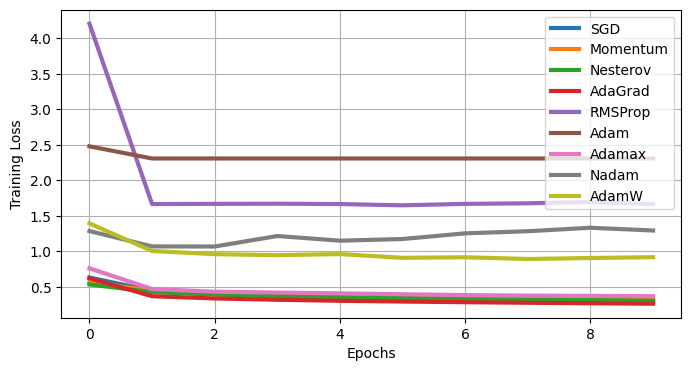

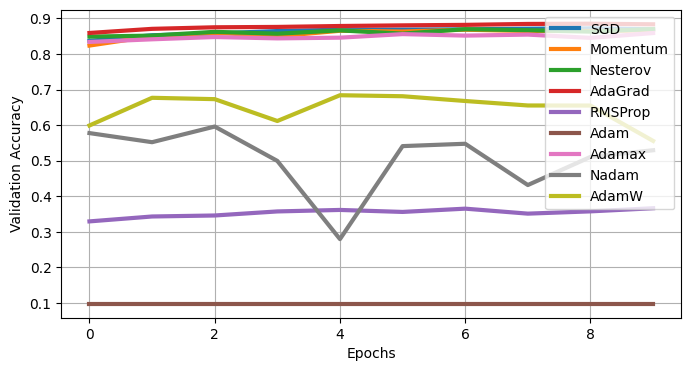

In [49]:
for plot in ("train_losses", "valid_metrics"):
    plt.figure(figsize=(8,4))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                 history_adagrad, history_rmsprop, history_adam,
                                 history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history[plot], label = opt_name, linewidth=3)
    plt.grid()
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.ylabel({"train_losses": "Training Loss", "valid_metrics": "Validation Accuracy"}[plot])

plt.show()